In [29]:
import pandas as pd
import os
import pprint
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="darkgrid")


In [15]:
data_dir = '../data'

oilspills_csvpath = os.path.join(data_dir, 'US_oilspills.csv')

### Loading Data

Initial findings from loading data:
-  3710 rows of data, each has an ID, open_date, name, lat and lon. 
-  We drop all the columns with all NaN values as these contain no useful information
-  We also drop the row of index '8039' as this is the only one with data inside the other 'field' columns (12/13/14/15/24/25 with 1 non-null value each) and is an outlier. This may infact contain useful information however we are unsure what to do with it and want to visualise the bulk of our data with a simple version 1 right now. This could be a future endeavour
-  It is unsure what field_10 represents, this could be important and a future task could be to include it. However, for now we remove it as it has no meaning right now.
-  It looks like field_11 contains furthe information. So we will rename the column as such.

So we create a function to load and format our data with the above points in mind.
We would be left with columns:
-  id
-  open_date: YYYY-DD-MM ex. 2020-02-27, granularity of days
-  name 
-  location: String Description of location
-  lat
-  lon
-  threat: Oil/Chemical/Other
-  commodity
-  max_ptl_release_gallons: Floating Value
-  description

In [5]:
def load_oilspills(csvpath: str) -> pd.DataFrame:
    
    oilspills = pd.read_csv(csvpath, 
                            index_col='id', 
                            parse_dates=['open_date'])

    # remove anomalous row (contains additional fields in columns)
    row_8039 = oilspills[oilspills['field_12'].notna()]
    oilspills = oilspills.drop(row_8039.index)

    # drop columns with NaN values
    oilspills = oilspills.dropna(axis=1, how='all')

    # drop column: 'field_10'
    oilspills = oilspills.drop(['field_10'], axis=1)

    oilspills = oilspills.rename(columns={'field_11':'description'})
    
    return oilspills


In [14]:
oilspills = load_oilspills(oilspills_csvpath)
oilspills.head()

,open_date,name,location,lat,lon,threat,commodity,max_ptl_release_gallons,description
id,,,,,,,,,
10049,2020-02-27,Partially Submerged Recreational Vessel Huron ...,"Huron, OH",41.391532,-82.554591,Oil,NaN,NaN,"On February 27, 2020, SSC received notificatio..."
10050,2020-02-27,Whitney Tank Battery 160 Loomis Pass Spill,"Venice, LA, USA",29.116625,-89.180917,Oil,NaN,NaN,"On February 27, 2020, the USCG Sector New Orle..."
10048,2020-02-24,Gray whale carcass,"Port Hueneme, CA",34.149744,-119.208226,Other,NaN,NaN,"On 24-FEB-2020, NMFS Stranding Coordinator in ..."
10047,2020-02-20,Recreational vessel sunk in Anacortes Skyline ...,"2400 Skyline Way, Anacortes, WA 98221, USA",48.492559,-122.680368,Oil,NaN,NaN,"On February 20, 2020, the SEA WOLF, a 44 foot ..."
10046,2020-02-17,North Santiam River - Truck Spill,"N Santiam Hwy, Detroit, OR 97342, USA",44.697000,-122.226890,Oil,NaN,NaN,On the morning of 16 FEB 2020 along the Santi...


With that, we can try to discover more about our dataset through visualiastions.

In [22]:
earliest_incident_date = min(oilspills['open_date'])
latest_incident_date = max(oilspills['open_date'])

print(f"Earliest Incident Occurred on: {earliest_incident_date}")
print(f"Latest Incident Occurred on: {latest_incident_date}")

Earliest Incident Occurred on: 1957-03-29 00:00:00
Latest Incident Occurred on: 2020-11-02 00:00:00


### Initial Exploration of Data with Simple Non-Interactive Plots

Findings that emerge:
-  Oilspills are the most common threat type
-  The number of oilspills spiked aorund 1985 and afte 2002/2003. Before this, the number of oilspills were very sparse. This can also be said for other threat types (chemical and other). Here we could also question how our data was collected for possible explanations for this phenomena
-  Total number of incidents does not appear to vary too widely depending on month by visual observation. Largest difference is between month 7 and 2 (July and February respectively) with a peak value around 190 and a minimum value nearing 150 counts for oil threats

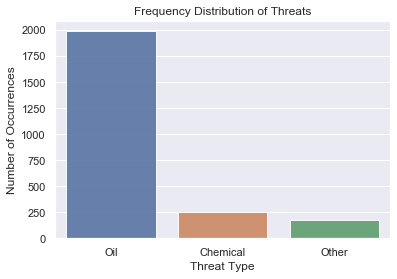

In [41]:
threat_count = oilspills['threat'].value_counts()

sns.barplot(threat_count.index, threat_count.values, alpha=0.9)

plt.title('Frequency Distribution of Threats')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Threat Type', fontsize=12)
plt.show()

Group by years and months to observe the changes over time

In [45]:
# add year and month columns
oilspills['year'] = pd.DatetimeIndex(oilspills['open_date']).year
oilspills['month'] = pd.DatetimeIndex(oilspills['open_date']).month

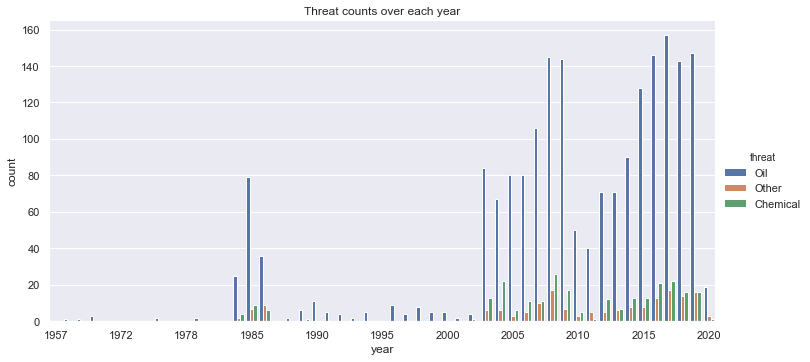

In [53]:
# plot by year
g = sns.catplot("year", 
                data=oilspills, 
                aspect=2,
                kind="count", 
                hue='threat')
g.set_xticklabels(step=5)

plt.title('Threat counts over each year')
plt.show()

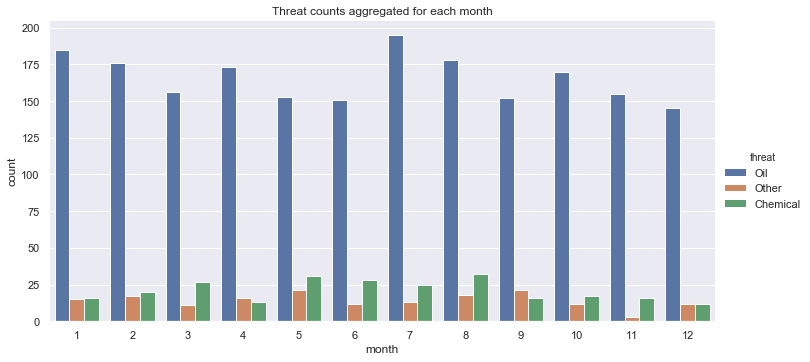

In [62]:
# plot by month
g = sns.catplot("month", 
                data=oilspills, 
                aspect=2,
                kind="count", 
                hue='threat')
g.set_xticklabels(step=1)

plt.title('Threat counts aggregated for each month')
plt.show()

Take a look at max_ptl_release_gallons and plot the counts and mean over each year. This could be interesting.

In [24]:
oilspills['commodity'].value_counts()
# seems like we have some cases where upper case is the same as lower case. 

Diesel                                   253
diesel                                   248
Oil                                       90
Crude Oil                                 62
crude oil                                 61
                                        ... 
Vacuum Gas Oil                             1
calcium chloride solution                  1
North Slope Alaskan crude                  1
Epichlorhydrin                             1
900 gallons diesel, 200,000 lbs. fish      1
Name: commodity, Length: 1392, dtype: int64